**Program**: 7_NSCH_AHR_Random_Forest_Analysis<br>
**Class**: Fall 2025, Machine Learning, Project<br>
**Member**: Vanessa Thorsten<br>
**Description**: This program reads in the analysis dataset NSCH_fam.csv, which provides data at the child-level and requires weighting the data due to the sampling and response. Variables are kept and Random Forest analysis is performed.<br>
<br>
**Outputs**: The following data visualizations are provided for the dataset:<br>

**Program History/Modifications**:<br>
10/14/2025    Initial Version

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, recall_score, classification_report
from sklearn.metrics import make_scorer #use for weighted roc auc
from sklearn.tree import plot_tree

from sklearn.inspection import PartialDependenceDisplay

In [2]:
#Combined state level data
df_fam = pd.read_csv("NSCH_fam.csv")
df_fam.head()

,Unnamed: 0,FIPSST,STATE,STATE_NAME,STRATUM,HHID,FORMTYPE,TOTKIDS_R,FWC,SC_AGE_YEARS,...,K4Q01,GOWHENSICK,UsualSck_23,smAdeqIns_23,smForgoneHC_23,nomAnxietyDep12to17_23,nomFlrish6mto5_23,nomFlrish6to17_23,ScreenTime_23,HrsSleep_23
0,0,6,CA,California,1,23043707,2,1,1318.476840,11,...,2.0,NaN,2.0,1.0,2.0,NaN,90.0,2.0,4.0,2.0
1,1,6,CA,California,1,23120547,3,2,978.499881,14,...,1.0,1.0,1.0,1.0,2.0,2.0,90.0,1.0,5.0,1.0
2,2,6,CA,California,1,23197456,3,1,904.191765,17,...,1.0,NaN,NaN,1.0,2.0,2.0,90.0,1.0,4.0,1.0
3,3,6,CA,California,1,23197458,3,2,1092.097256,12,...,1.0,1.0,1.0,1.0,2.0,2.0,90.0,1.0,4.0,1.0
4,4,6,CA,California,1,23235909,2,2,586.387870,10,...,2.0,NaN,2.0,2.0,2.0,NaN,90.0,1.0,5.0,1.0


In [3]:
df_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54159 entries, 0 to 54158
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              54159 non-null  int64  
 1   FIPSST                  54159 non-null  int64  
 2   STATE                   54159 non-null  object 
 3   STATE_NAME              54159 non-null  object 
 4   STRATUM                 54159 non-null  int64  
 5   HHID                    54159 non-null  int64  
 6   FORMTYPE                54159 non-null  int64  
 7   TOTKIDS_R               54159 non-null  int64  
 8   FWC                     54159 non-null  float64
 9   SC_AGE_YEARS            54159 non-null  int64  
 10  SC_SEX                  54159 non-null  int64  
 11  age3_23                 54159 non-null  int64  
 12  age5_23                 54159 non-null  int64  
 13  sex_23                  54159 non-null  int64  
 14  hispanic_23             54159 non-null

In [4]:
# Outcome of interest is teens geeting adequate sleep for their age.
# Filter the data to teens
df_teen = df_fam[df_fam['SC_AGE_YEARS'] > 12].copy()

In [5]:
#Add labeled variable for graphs
hrssleep_labels = {
    1: 'Adequate for age',
    2: 'Inadequate for age'
}

hrssleep_order = ['Adequate for age', 'Inadequate for age']

df_teen['HrsSleep_labeled'] = df_teen['HrsSleep_23'].map(hrssleep_labels)

#Add 0/1 variable for models. 1 -> 0 (adequate sleep), 2 -> 1 (inadequate sleep), NAN stays NAN
df_teen['inadequate_sleep'] = df_teen['HrsSleep_23'].map({1: 0, 2: 1}).astype('Int64')

In [6]:
cols = ['HrsSleep_23', 'inadequate_sleep', 'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23',
        'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01']

for col in cols:
    print(f"{df_teen[col].value_counts()}\n")

# FoodCash_23 is 1= someone in house received food/cash assistance during the past 12 months from 3-5 sources
#                2= someone in house received food/cash assistance during the past 12 months from 1-2 sources
#                3= did not receive food/cash assistance during the past 12 months


HrsSleep_23
1.0    10980
2.0     4272
Name: count, dtype: int64

inadequate_sleep
0    10980
1     4272
Name: count, dtype: Int64

ScreenTime_23
5.0    5631
3.0    3956
4.0    3943
2.0    1211
1.0     468
Name: count, dtype: int64

SC_AGE_YEARS
16    3453
17    3370
15    3099
14    2741
13    2728
Name: count, dtype: int64

HousingInstab_23
2.0    13013
1.0     2113
Name: count, dtype: int64

FoodCash_23
1.0    10105
2.0     4015
3.0     1002
Name: count, dtype: int64

smAdeqIns_23
1.0    9814
2.0    5577
Name: count, dtype: int64

nomChHlthSt_23
1.0    13608
2.0     1783
Name: count, dtype: int64

PrevMed_23
1.0    11667
2.0     3724
Name: count, dtype: int64

K4Q01
1.0    12650
2.0     2741
Name: count, dtype: int64



In [7]:
# Using isna() to count NaNs in each column
column_nan_count_isna = df_teen[['HrsSleep_23', 'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23', 'FoodCash_23', 
'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01', 'FWC']].isna().sum()
print("NaN count per column using isna():") 
print(column_nan_count_isna)

NaN count per column using isna():
HrsSleep_23         139
ScreenTime_23       182
SC_AGE_YEARS          0
HousingInstab_23    265
FoodCash_23         269
smAdeqIns_23          0
nomChHlthSt_23        0
PrevMed_23            0
K4Q01                 0
FWC                   0
dtype: int64


In [8]:
# Subset to relevant variables
df_teen_rf = df_teen[['inadequate_sleep', 'HrsSleep_23', 'HrsSleep_labeled', 'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23',
                      'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23',
                      'K4Q01', 'FWC']].copy()

# Fill missing values with the mode (most frequent value) for each column
for col in df_teen_rf.columns:
    mode = df_teen_rf[col].mode(dropna=True)
    if not mode.empty:
        df_teen_rf[col] = df_teen_rf[col].fillna(mode[0])
    else:
        print(f"Warning: No mode found for column '{col}' — possibly all NaNs.")


In [9]:
#convert from float to int
cols_to_convert = ['HrsSleep_23', 'ScreenTime_23', 'HousingInstab_23',
                   'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23',
                   'PrevMed_23', 'K4Q01']

df_teen_rf[cols_to_convert] = df_teen_rf[cols_to_convert].astype('int64')

In [10]:
column_nan_count_isna = df_teen_rf[['inadequate_sleep', 'HrsSleep_23', 'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23', 'FoodCash_23', 
'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01', 'FWC']].isna().sum()
print("NaN count per column using isna():") 
print(column_nan_count_isna)

NaN count per column using isna():
inadequate_sleep    0
HrsSleep_23         0
ScreenTime_23       0
SC_AGE_YEARS        0
HousingInstab_23    0
FoodCash_23         0
smAdeqIns_23        0
nomChHlthSt_23      0
PrevMed_23          0
K4Q01               0
FWC                 0
dtype: int64


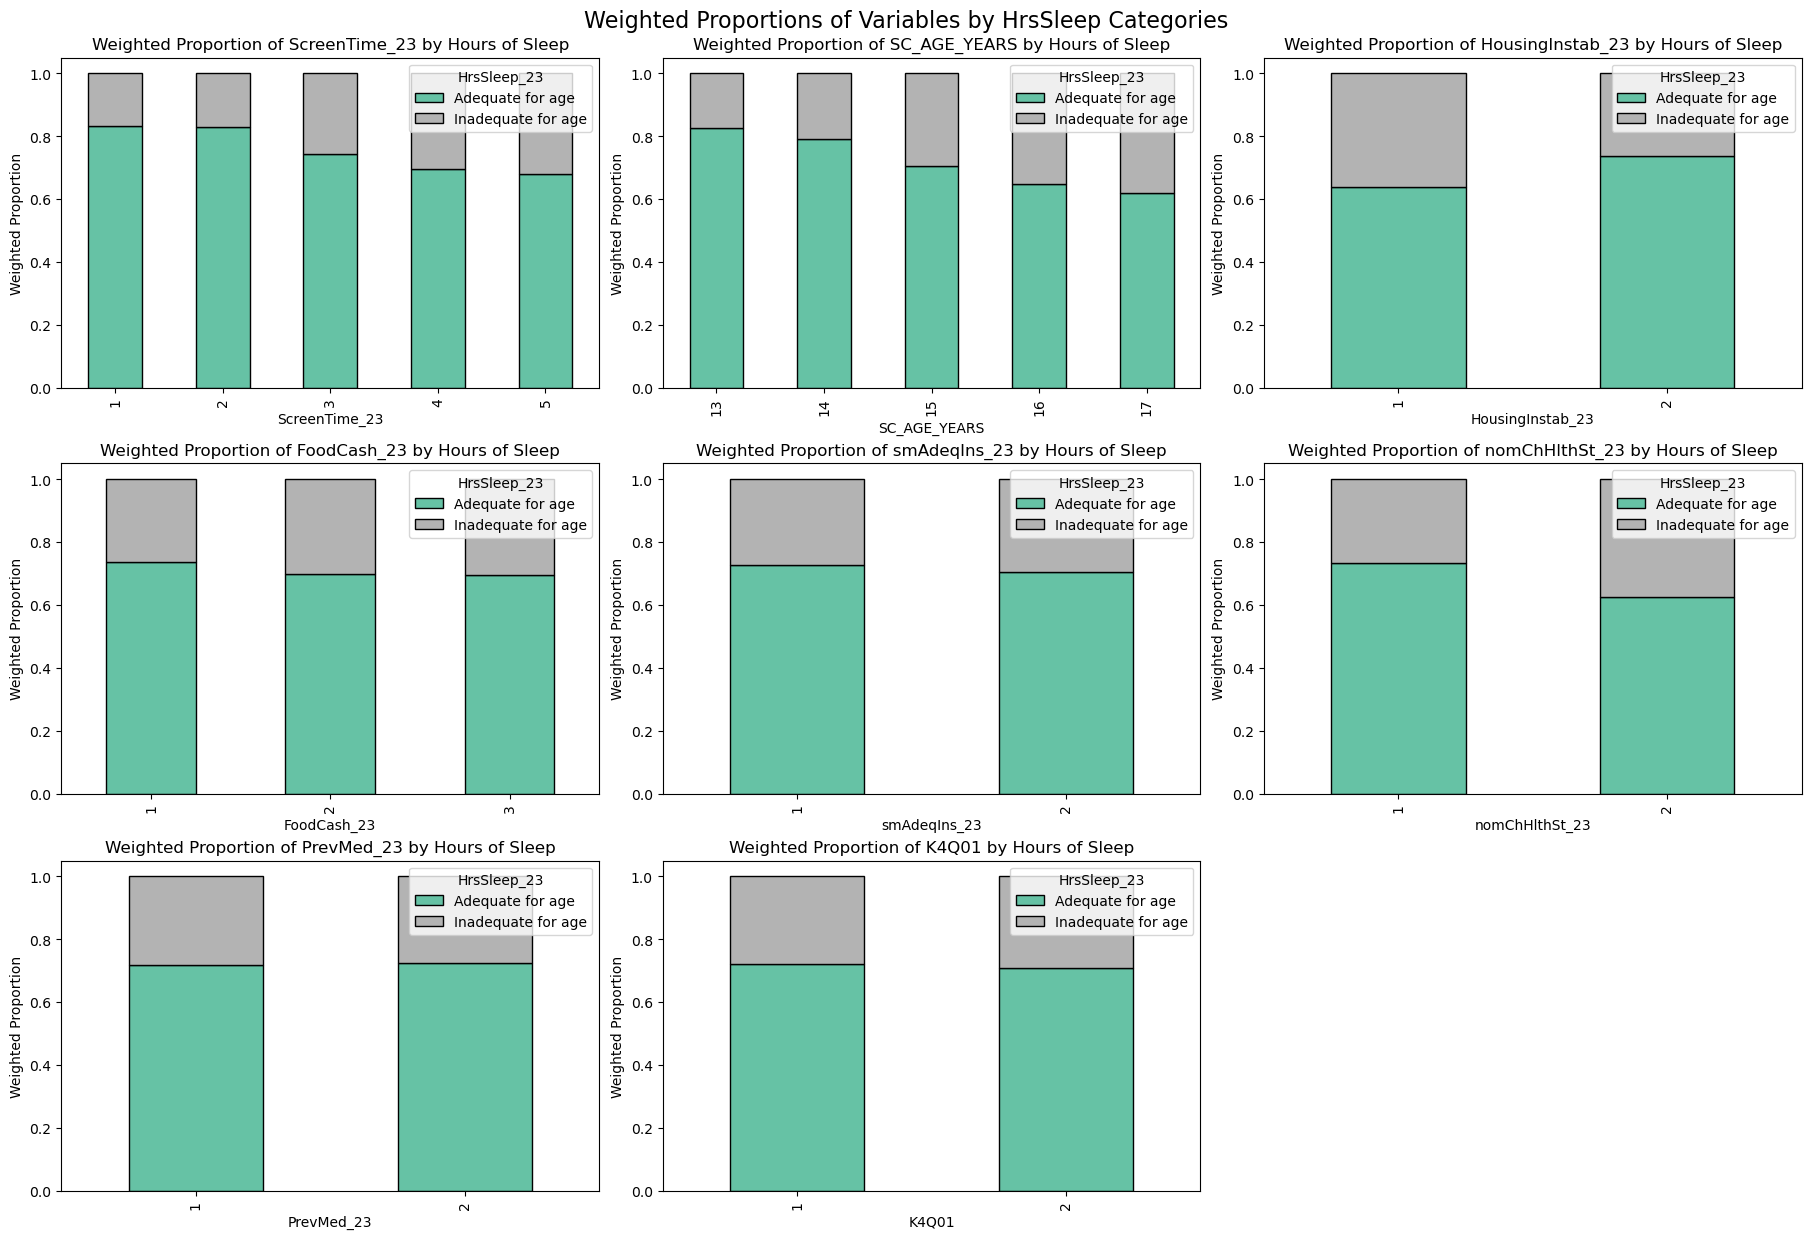

In [11]:
vars_to_plot = [
    'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23',
    'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01'
]

n_vars = len(vars_to_plot)
cols = 3
rows = math.ceil(n_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), constrained_layout=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    # Calculate weighted counts by variable and hue
    weighted_counts = (
        df_teen_rf
        .groupby([var, 'HrsSleep_labeled'], dropna=False)['FWC']
        .sum()
        .reset_index()
        .rename(columns={'FWC': 'weighted_count'})
    )

    # Calculate total weighted counts per variable value
    total_counts = (
        weighted_counts
        .groupby(var)['weighted_count']
        .sum()
        .reset_index()
        .rename(columns={'weighted_count': 'total_weighted_count'})
    )

    # Merge totals back to weighted_counts to calculate proportions
    merged = weighted_counts.merge(total_counts, on=var)
    merged['prop'] = merged['weighted_count'] / merged['total_weighted_count']

    # Pivot for plotting stacked bars
    pivot_df = merged.pivot(index=var, columns='HrsSleep_labeled', values='prop').fillna(0)

    # Sort index if possible (depends on your data type)
    pivot_df = pivot_df.sort_index()

    # Plot stacked bar
    pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='Set2', edgecolor='black')

    ax.set_title(f"Weighted Proportion of {var} by Hours of Sleep")
    ax.set_xlabel(var)
    ax.set_ylabel("Weighted Proportion")
    ax.legend(title='HrsSleep_23')

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Weighted Proportions of Variables by HrsSleep Categories', fontsize=16, y=1.02)
plt.show()



### Convert categorical variables to dummy variables
- ScreenTime_23: 1, 2, 3, 4, 5
- Age: 13, 14, 15, 16, 17
- Housing instability: 1, 2
- Someone in family received food or cash in last 12 months: 1, 2, 3
- Adequate and continuous insurance: 1, 2
- Good health: 1, 2
- Preventative care: 1, 2
- Place for care (K4Q01): 1, 2

In [12]:
df_teen_rf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15391 entries, 1 to 54152
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   inadequate_sleep  15391 non-null  Int64  
 1   HrsSleep_23       15391 non-null  int64  
 2   HrsSleep_labeled  15391 non-null  object 
 3   ScreenTime_23     15391 non-null  int64  
 4   SC_AGE_YEARS      15391 non-null  int64  
 5   HousingInstab_23  15391 non-null  int64  
 6   FoodCash_23       15391 non-null  int64  
 7   smAdeqIns_23      15391 non-null  int64  
 8   nomChHlthSt_23    15391 non-null  int64  
 9   PrevMed_23        15391 non-null  int64  
 10  K4Q01             15391 non-null  int64  
 11  FWC               15391 non-null  float64
dtypes: Int64(1), float64(1), int64(9), object(1)
memory usage: 1.5+ MB


In [13]:
# Define your categorical columns
cat_cols = ['ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23',
            'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01']

# Instantiate the encoder
encoder = OneHotEncoder(drop=None, sparse_output=False, dtype=int)

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df_teen_rf[cat_cols])

# Get feature names for the new one-hot columns
encoded_cols = encoder.get_feature_names_out(cat_cols)

# Create a DataFrame from the encoded array
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df_teen_rf.index)

# Drop the original categorical columns
df_teen_rf_dropped = df_teen_rf.drop(columns=cat_cols)

# Concatenate the original (reduced) dataframe with the encoded columns
df_teen_rf2 = pd.concat([df_teen_rf_dropped, encoded_df], axis=1)

In [14]:
df_teen_rf2['inadequate_sleep'].value_counts()

inadequate_sleep
0    11119
1     4272
Name: count, dtype: Int64

In [15]:
df_teen_rf2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15391 entries, 1 to 54152
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inadequate_sleep    15391 non-null  Int64  
 1   HrsSleep_23         15391 non-null  int64  
 2   HrsSleep_labeled    15391 non-null  object 
 3   FWC                 15391 non-null  float64
 4   ScreenTime_23_1     15391 non-null  int32  
 5   ScreenTime_23_2     15391 non-null  int32  
 6   ScreenTime_23_3     15391 non-null  int32  
 7   ScreenTime_23_4     15391 non-null  int32  
 8   ScreenTime_23_5     15391 non-null  int32  
 9   SC_AGE_YEARS_13     15391 non-null  int32  
 10  SC_AGE_YEARS_14     15391 non-null  int32  
 11  SC_AGE_YEARS_15     15391 non-null  int32  
 12  SC_AGE_YEARS_16     15391 non-null  int32  
 13  SC_AGE_YEARS_17     15391 non-null  int32  
 14  HousingInstab_23_1  15391 non-null  int32  
 15  HousingInstab_23_2  15391 non-null  int32  
 16  FoodCash_

In [16]:
# Double check that distributions look right for the dummy variables
print(df_teen_rf['ScreenTime_23'].value_counts(normalize=True))
print (df_teen_rf2[['ScreenTime_23_1', 'ScreenTime_23_2', 'ScreenTime_23_3', 'ScreenTime_23_4', 'ScreenTime_23_5']].mean())
print(df_teen_rf['SC_AGE_YEARS'].value_counts(normalize=True))
print (df_teen_rf2[['SC_AGE_YEARS_13', 'SC_AGE_YEARS_14', 'SC_AGE_YEARS_15', 'SC_AGE_YEARS_16', 'SC_AGE_YEARS_17']].mean())
print(df_teen_rf['HousingInstab_23'].value_counts(normalize=True))
print (df_teen_rf2[['HousingInstab_23_1', 'HousingInstab_23_2']].mean())
print(df_teen_rf['FoodCash_23'].value_counts(normalize=True))
print (df_teen_rf2[['FoodCash_23_1', 'FoodCash_23_2', 'FoodCash_23_3']].mean())
print(df_teen_rf['smAdeqIns_23'].value_counts(normalize=True))
print (df_teen_rf2[['smAdeqIns_23_1', 'smAdeqIns_23_2']].mean())
print(df_teen_rf['nomChHlthSt_23'].value_counts(normalize=True))
print (df_teen_rf2[['nomChHlthSt_23_1', 'nomChHlthSt_23_2']].mean())
print(df_teen_rf['PrevMed_23'].value_counts(normalize=True))
print (df_teen_rf2[['PrevMed_23_1', 'PrevMed_23_2']].mean())
print(df_teen_rf['K4Q01'].value_counts(normalize=True))
print (df_teen_rf2[['K4Q01_1', 'K4Q01_2']].mean())

ScreenTime_23
5    0.377688
3    0.257033
4    0.256189
2    0.078682
1    0.030407
Name: proportion, dtype: float64
ScreenTime_23_1    0.030407
ScreenTime_23_2    0.078682
ScreenTime_23_3    0.257033
ScreenTime_23_4    0.256189
ScreenTime_23_5    0.377688
dtype: float64
SC_AGE_YEARS
16    0.224352
17    0.218959
15    0.201351
14    0.178091
13    0.177246
Name: proportion, dtype: float64
SC_AGE_YEARS_13    0.177246
SC_AGE_YEARS_14    0.178091
SC_AGE_YEARS_15    0.201351
SC_AGE_YEARS_16    0.224352
SC_AGE_YEARS_17    0.218959
dtype: float64
HousingInstab_23
2    0.862712
1    0.137288
Name: proportion, dtype: float64
HousingInstab_23_1    0.137288
HousingInstab_23_2    0.862712
dtype: float64
FoodCash_23
1    0.674030
2    0.260867
3    0.065103
Name: proportion, dtype: float64
FoodCash_23_1    0.674030
FoodCash_23_2    0.260867
FoodCash_23_3    0.065103
dtype: float64
smAdeqIns_23
1    0.637645
2    0.362355
Name: proportion, dtype: float64
smAdeqIns_23_1    0.637645
smAdeqIns_23_2  

### Drop reference level for dummy variables

In [17]:
#Delete the dummy variables corresponding to the reference level 
#Pick the category with the least risk for inadequate sleep
#Least amount of screentime, youngest age group, no housing instability,
#No food/cash assistance, adequate and continuous health insurance,
#Good or excellent health, having preventative healthcare,
#having a place to get care

df_teen_rf3=df_teen_rf2.drop(['ScreenTime_23_1', 'SC_AGE_YEARS_13','HousingInstab_23_2','FoodCash_23_3',
                              'smAdeqIns_23_1', 'nomChHlthSt_23_1','PrevMed_23_1', 'K4Q01_1'], axis=1).copy()
df_teen_rf3.shape
df_teen_rf3.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 15391 entries, 1 to 54152
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inadequate_sleep    15391 non-null  Int64  
 1   HrsSleep_23         15391 non-null  int64  
 2   HrsSleep_labeled    15391 non-null  object 
 3   FWC                 15391 non-null  float64
 4   ScreenTime_23_2     15391 non-null  int32  
 5   ScreenTime_23_3     15391 non-null  int32  
 6   ScreenTime_23_4     15391 non-null  int32  
 7   ScreenTime_23_5     15391 non-null  int32  
 8   SC_AGE_YEARS_14     15391 non-null  int32  
 9   SC_AGE_YEARS_15     15391 non-null  int32  
 10  SC_AGE_YEARS_16     15391 non-null  int32  
 11  SC_AGE_YEARS_17     15391 non-null  int32  
 12  HousingInstab_23_1  15391 non-null  int32  
 13  FoodCash_23_1       15391 non-null  int32  
 14  FoodCash_23_2       15391 non-null  int32  
 15  smAdeqIns_23_2      15391 non-null  int32  
 16  nomChHlth

In [18]:
df_teen_rf3['inadequate_sleep'].value_counts()

inadequate_sleep
0    11119
1     4272
Name: count, dtype: Int64

In [19]:
# Displaying the data before splitting
features = ['ScreenTime_23_2','ScreenTime_23_3','ScreenTime_23_4','ScreenTime_23_5',
            'SC_AGE_YEARS_14', 'SC_AGE_YEARS_15', 'SC_AGE_YEARS_16', 'SC_AGE_YEARS_17',
            'HousingInstab_23_1', 'FoodCash_23_1', 'FoodCash_23_2', 'smAdeqIns_23_2',
            'nomChHlthSt_23_2','PrevMed_23_2', 'K4Q01_2']

target = 'inadequate_sleep'

FWC = df_teen_rf['FWC']

display(df_teen_rf3[features].head())
display(df_teen_rf3[target].head())

,ScreenTime_23_2,ScreenTime_23_3,ScreenTime_23_4,ScreenTime_23_5,SC_AGE_YEARS_14,SC_AGE_YEARS_15,SC_AGE_YEARS_16,SC_AGE_YEARS_17,HousingInstab_23_1,FoodCash_23_1,FoodCash_23_2,smAdeqIns_23_2,nomChHlthSt_23_2,PrevMed_23_2,K4Q01_2
1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0
5,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
6,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0
9,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0


1    0
2    0
5    0
6    0
9    1
Name: inadequate_sleep, dtype: Int64

In [20]:
# Splitting the dataset into the Training set and Test set
# Add stratify=y to maintain class-balanced split, maintain label proportions and improve reliability

X_train, X_test, y_train, y_test, FWC_train, FWC_test = train_test_split(df_teen_rf3[features],df_teen_rf3[target],FWC, 
                                                                         test_size=0.2,random_state=4567, stratify=df_teen_rf3[target])

In [21]:
# No. of instance with 1 in target variable for training set
display(y_train.value_counts()) #roughly unweighted 27.8% of the data has inadequate sleep

# No. of instance with 1 in target variable for test set
display(y_test.value_counts()) #roughly unweighted 28.7% of the data has inadequate sleep

inadequate_sleep
0    8895
1    3417
Name: count, dtype: Int64

inadequate_sleep
0    2224
1     855
Name: count, dtype: Int64

In [22]:
# display the data after splitting

# Training set
display(pd.DataFrame(X_train).head())
display(pd.DataFrame(y_train).head())

# Test set
display(pd.DataFrame(X_test).head())
display(pd.DataFrame(y_test).head())
 

,ScreenTime_23_2,ScreenTime_23_3,ScreenTime_23_4,ScreenTime_23_5,SC_AGE_YEARS_14,SC_AGE_YEARS_15,SC_AGE_YEARS_16,SC_AGE_YEARS_17,HousingInstab_23_1,FoodCash_23_1,FoodCash_23_2,smAdeqIns_23_2,nomChHlthSt_23_2,PrevMed_23_2,K4Q01_2
47472,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
45685,0,1,0,0,0,0,1,0,1,1,0,0,0,1,1
7995,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0
6645,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1
40382,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1


,inadequate_sleep
47472,0
45685,0
7995,0
6645,0
40382,0


,ScreenTime_23_2,ScreenTime_23_3,ScreenTime_23_4,ScreenTime_23_5,SC_AGE_YEARS_14,SC_AGE_YEARS_15,SC_AGE_YEARS_16,SC_AGE_YEARS_17,HousingInstab_23_1,FoodCash_23_1,FoodCash_23_2,smAdeqIns_23_2,nomChHlthSt_23_2,PrevMed_23_2,K4Q01_2
27458,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
18059,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
38382,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
30179,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0
19146,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0


,inadequate_sleep
27458,0
18059,0
38382,0
30179,0
19146,1


In [23]:
# Do not need to scale the data for a random forest analysis
# Displaying the training set

display(pd.DataFrame(X_train).head())

,ScreenTime_23_2,ScreenTime_23_3,ScreenTime_23_4,ScreenTime_23_5,SC_AGE_YEARS_14,SC_AGE_YEARS_15,SC_AGE_YEARS_16,SC_AGE_YEARS_17,HousingInstab_23_1,FoodCash_23_1,FoodCash_23_2,smAdeqIns_23_2,nomChHlthSt_23_2,PrevMed_23_2,K4Q01_2
47472,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
45685,0,1,0,0,0,0,1,0,1,1,0,0,0,1,1
7995,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0
6645,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1
40382,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1


In [24]:
# Implementing random forest classifier
# The random forest classifiers are going to look for thresholds within the features that might
# be indicative of good insurance coverage then this will be the criterias for which 
#the splits will be set 
#look whichever split is going to maximize the information gain (or minimize the impurity)
#will be chosen as the split point.

classifier = RandomForestClassifier(class_weight='balanced', random_state=4567) 
classifier.fit(X_train, y_train, sample_weight = FWC_train)

#X_train - the training features whose values may induce insurance coverage thresholds
#y_train - the coorresponding targer variable (0 or 1) for the training features

RandomForestClassifier(class_weight='balanced', random_state=4567)

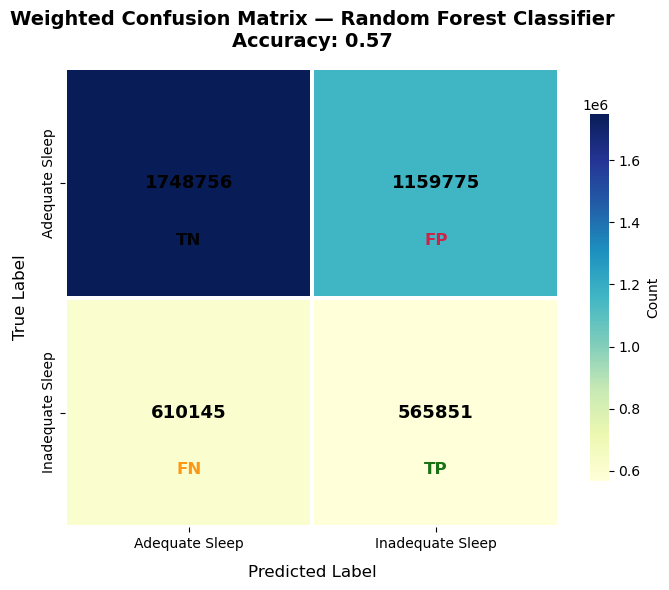

In [25]:
# Generating the confusion matrix

# Predictions
preds = classifier.predict(X_test)

# Compute weighted confusion matrix and weighted accuracy
conf_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': preds,
    'weight': FWC_test
})

# Group by true and predicted labels and sum weights
weighted_cm = conf_df.groupby(['y_true', 'y_pred'])['weight'].sum().unstack(fill_value=0)

# Ensure matrix shape is 2x2
weighted_cm = weighted_cm.reindex(index=[0,1], columns=[0,1], fill_value=0).values.astype(int)

acc = accuracy_score(y_test, preds, sample_weight=FWC_test)

# Class labels
labels = ["Adequate Sleep", "Inadequate Sleep"]

# Plot setup
plt.figure(figsize=(7,6))
ax = sns.heatmap(weighted_cm, annot=True, fmt='d',
                 cmap='YlGnBu',
                 linewidths=1.5, linecolor='white',
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'shrink':0.8, 'label':'Count'},
                 annot_kws={'size':13, 'weight':'bold', 'color':'black'})

plt.title(f"Weighted Confusion Matrix — Random Forest Classifier\nAccuracy: {acc:.2f}",
          fontsize=14, weight='bold', pad=15)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)

# Label coordinates (slightly below numeric counts)
offset_y = 0.25  # small downward shift from center

# Overlay TN / FP / FN / TP *below* the numbers
for i in range(weighted_cm.shape[0]):
    for j in range(weighted_cm.shape[1]):
        if i == 0 and j == 0:
            label, color = "TN", "black"
        elif i == 0 and j == 1:
            label, color = "FP", "crimson"
        elif i == 1 and j == 0:
            label, color = "FN", "darkorange"
        else:
            label, color = "TP", "darkgreen"

        ax.text(j + 0.5, i + 0.5 + offset_y, label,
                color=color, fontsize=12, weight='bold',
                ha='center', va='center', alpha=0.9)

plt.tight_layout()
plt.show()

In [26]:
print(weighted_cm)

[[1748756 1159775]
 [ 610145  565851]]


In [27]:
# Accuracy, F1 Score and Recall Score

# See final program for text on what these are

accuracy = accuracy_score(y_test, preds, sample_weight=FWC_test)
f1 = f1_score(y_test, preds, sample_weight=FWC_test)
recall = recall_score(y_test, preds, sample_weight=FWC_test)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.57
F1 Score: 0.39
Recall: 0.48


In [28]:
# Predict the test set probabilities of the positive class
y_pred_proba_rf = classifier.predict_proba(X_test)[:,1]
test_roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf, sample_weight=FWC_test)
# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc_rf))

Test set ROC AUC score: 0.584


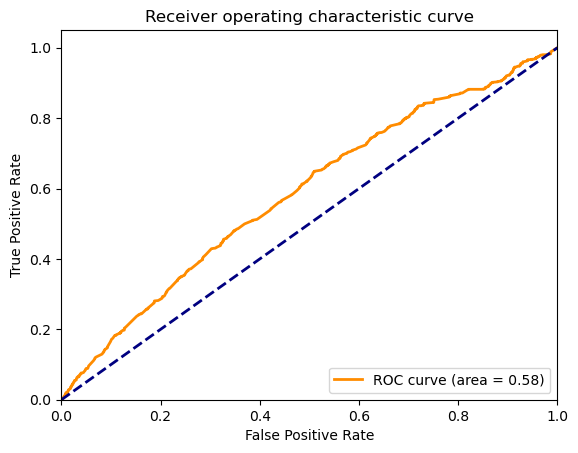

In [29]:
## ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
print (classifier.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 4567, 'verbose': 0, 'warm_start': False}


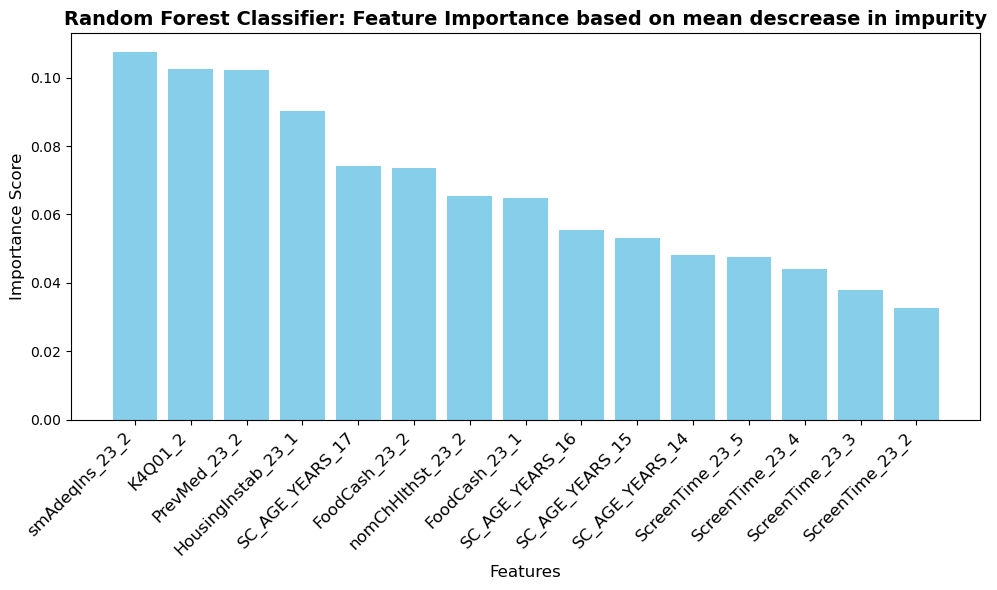

In [31]:
# visualizing the feature importance
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Random Forest Classifier: Feature Importance based on mean descrease in impurity", fontsize=14, weight='bold')
plt.bar(range(X_train.shape[1]),importances[indices],align='center',color='skyblue')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=45, ha='right', fontsize=12)
plt.xlabel("Features",fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.tight_layout()
plt.show()

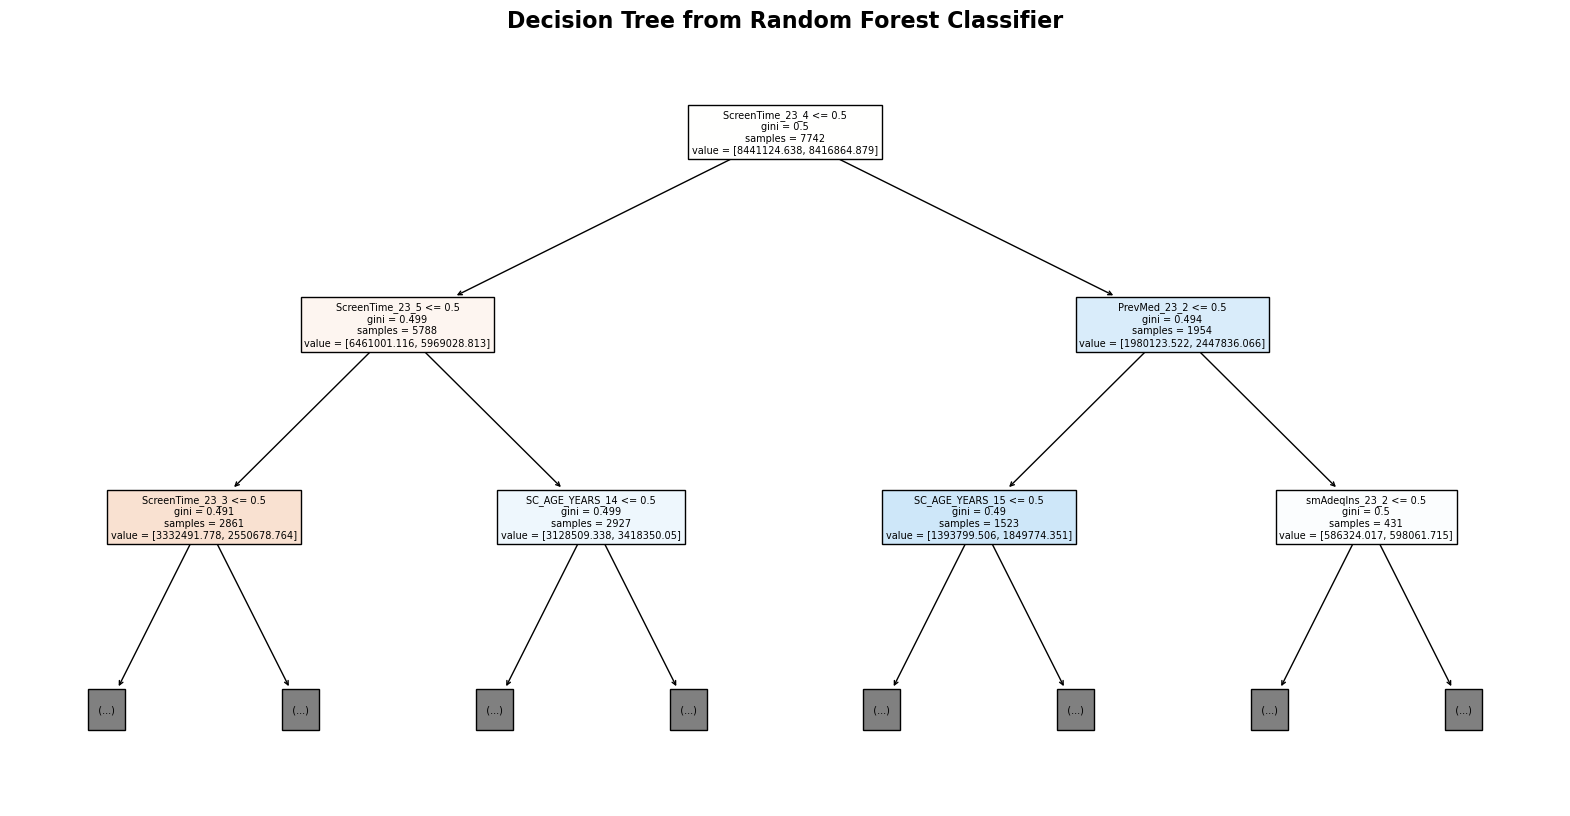

In [32]:
#Plot the first decision tree in the random forest

plt.figure(figsize = (20,10))
plot_tree(classifier.estimators_[0], feature_names=features, filled = True, max_depth = 2)
plt.title("Decision Tree from Random Forest Classifier", fontsize=16, weight='bold')
plt.show()

### Partial dependence plots 
Look for the directionality of the results.

Partial dependence plots show the dependence between the target function and a set of ‘target’ features, marginalizing over the values of all other features (the complement features). 

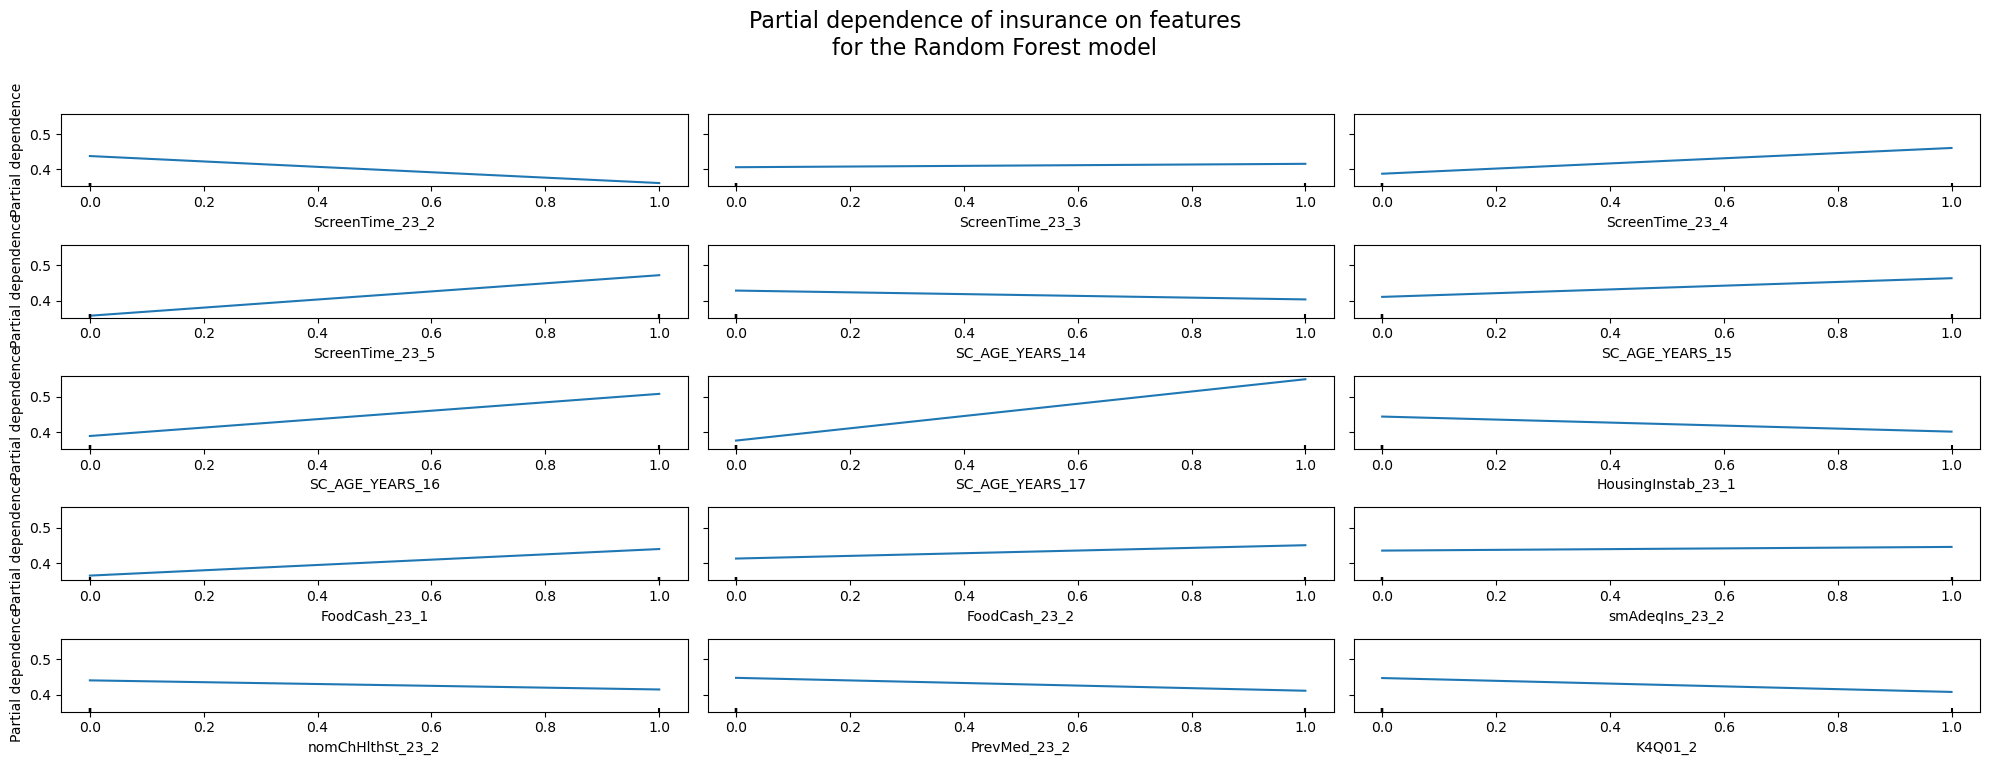

In [33]:
features=['ScreenTime_23_2','ScreenTime_23_3','ScreenTime_23_4','ScreenTime_23_5',
            'SC_AGE_YEARS_14', 'SC_AGE_YEARS_15', 'SC_AGE_YEARS_16', 'SC_AGE_YEARS_17',
            'HousingInstab_23_1', 'FoodCash_23_1', 'FoodCash_23_2', 'smAdeqIns_23_2',
            'nomChHlthSt_23_2','PrevMed_23_2', 'K4Q01_2']

# Create PDP with a grid layout and larger figure size
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20, 8))  # 2 rows, 5 columns
PartialDependenceDisplay.from_estimator(classifier, X_train, features, ax=ax)

# Set title and adjust layout
fig.suptitle('Partial dependence of insurance on features\nfor the Random Forest model', fontsize=16)
fig.subplots_adjust(wspace=0.3, hspace=0.4)  # spacing between plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for the suptitle
plt.show()

In [34]:
probs = classifier.predict_proba(X_test)[:, 1]

for t in [0.5, 0.4, 0.35, 0.3, 0.25]:
    preds_t = (probs >= t).astype(int)
    print(f"Threshold: {t}")
    print("Recall:", recall_score(y_test, preds_t, sample_weight=FWC_test))
    print("F1:", f1_score(y_test, preds_t, sample_weight=FWC_test))
    print("Accuracy:", accuracy_score(y_test, preds_t, sample_weight=FWC_test))
    print("-" * 30)

Threshold: 0.5
Recall: 0.48116756639452973
F1: 0.3900239863530025
Accuracy: 0.5666769003788342
------------------------------
Threshold: 0.4
Recall: 0.6521514266540609
F1: 0.4372879978968046
Accuracy: 0.5167619486697907
------------------------------
Threshold: 0.35
Recall: 0.6910611301719369
F1: 0.4341650600326274
Accuracy: 0.4813845958828669
------------------------------
Threshold: 0.3
Recall: 0.7606215584439474
F1: 0.4519642158626919
Accuracy: 0.46891070056677664
------------------------------
Threshold: 0.25
Recall: 0.8092901507888164
F1: 0.4645739441622725
Accuracy: 0.4629150744911884
------------------------------
